In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns


# Download NLTK data
nltk.download('punkt')

nltk.download('stopwords')

# Reload dataset
!wget https://raw.githubusercontent.com/justmarkham/pydata-dc-2016-tutorial/master/sms.tsv  -O imdb_demo.csv
df = pd.read_csv('imdb_demo.csv', sep='\t', header=None)
df.columns = ['label', 'text']

# Map ham/spam to positive/negative
df['sentiment'] = df['label'].map({'ham': 'positive', 'spam': 'negative'})

# Now map sentiment strings to numbers: positive=1, negative=0
df['sentiment_num'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Drop any rows with missing sentiment
df = df.dropna(subset=['sentiment_num'])

# Clean text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords.words('english')])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Split data
X = df['cleaned_text']
y = df['sentiment_num']  # This is now numeric (0 or 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2025-06-25 05:18:35--  https://raw.githubusercontent.com/justmarkham/pydata-dc-2016-tutorial/master/sms.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 477907 (467K) [text/plain]
Saving to: ‘imdb_demo.csv’

imdb_demo.csv       100%[===================>] 466.71K  --.-KB/s    in 0.05s   

2025-06-25 05:18:36 (9.56 MB/s) - ‘imdb_demo.csv’ saved [477907/477907]



In [3]:
#Feature Extraction: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [4]:
#Train a Machine Learning Model (Logistic Regression)
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
preds = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Accuracy: 0.9757847533632287
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       149
           1       0.97      1.00      0.99       966

    accuracy                           0.98      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



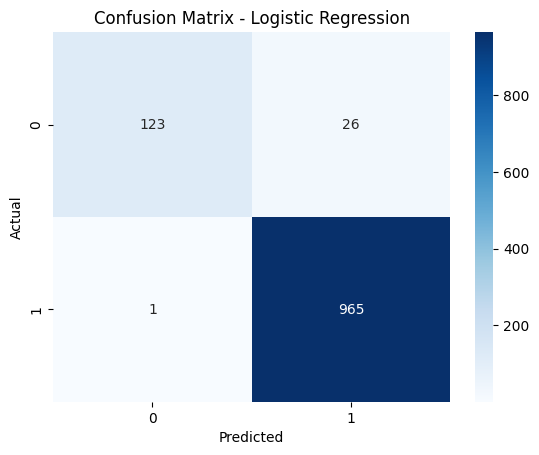

In [5]:
#Visualize Confusion Matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [6]:
#Deep Learning Approach: LSTM with Keras

#Tokenize and Pad Sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(seq_train, maxlen=100, padding='post', truncating='post')
padded_test = pad_sequences(seq_test, maxlen=100, padding='post', truncating='post')

In [7]:
# Ensure y_train and y_test are of type int64
y_train = np.array(y_train).astype('int64')
y_test = np.array(y_test).astype('int64')

In [8]:
#Build LSTM Model
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

# Now fit the model
history = model_lstm.fit(
    padded_train, y_train,
    epochs=5,
    validation_data=(padded_test, y_test),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8653 - loss: 0.4514 - val_accuracy: 0.8664 - val_loss: 0.3959
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8664 - loss: 0.4034 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8609 - loss: 0.4080 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8755 - loss: 0.3863 - val_accuracy: 0.8664 - val_loss: 0.3963
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8596 - loss: 0.4103 - val_accuracy: 0.8664 - val_loss: 0.3933


In [9]:
#Evaluate LSTM Model
loss, accuracy = model_lstm.evaluate(padded_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8793 - loss: 0.3694
Test Accuracy: 0.8664


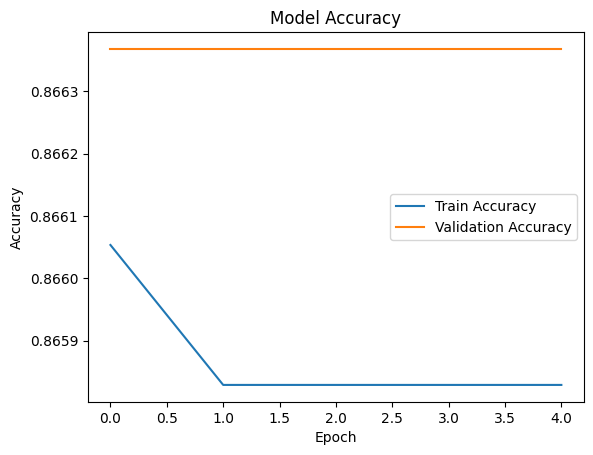

In [11]:
#Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()